# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [ ]:
# Install the required libraries
!pip install prophet

In [ ]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
%matplotlib inline

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?


Data Sliced: Focused on May 2020, the month of MercadoLibre's quarterly earnings release.
Visualization: A spike in search traffic likely coincides with the earnings release date.
Patterns: Expect to see increased search activity around the earnings release, reflecting heightened public interest.
This confirms that unusual patterns likely exist around key financial events.

In [ ]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=True
).dropna()

# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

<ipython-input-3-7b61da2eeee1>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends = pd.read_csv(


,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


In [ ]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


<ipython-input-5-ee8c55e3b41f>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends = pd.read_csv(


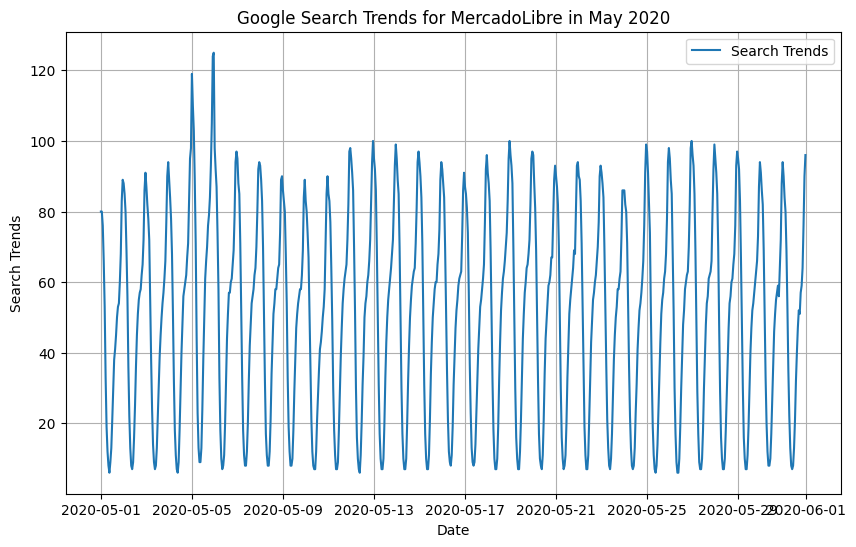

In [5]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.
import pandas as pd

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=True
).dropna()
# Slice the DataFrame to just the month of May 2020
may_2020_data = df_mercado_trends.loc['2020-05-01':'2020-05-31']

# Plot to visualize the data for May 2020
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(may_2020_data.index, may_2020_data['Search Trends'], label='Search Trends')
plt.xlabel('Date')
plt.ylabel('Search Trends')
plt.title('Google Search Trends for MercadoLibre in May 2020')
plt.legend()
plt.grid(True)
plt.show()

#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [6]:
# Calculate the sum of the total search traffic for May 2020
traffic_may_2020 = may_2020_data['Search Trends'].sum()


# View the traffic_may_2020 value
print(f"Total Search Traffic for May 2020: {traffic_may_2020}")


Total Search Traffic for May 2020: 38181


In [7]:
# Calcluate the monhtly median search traffic across all months
monthly_traffic = df_mercado_trends.resample('M').sum()
monthly_median_traffic = monthly_traffic['Search Trends'].median()
# Group the DataFrame by index year and then index month, chain the sum and then the median functions
median_monthly_traffic = df_mercado_trends.groupby([df_mercado_trends.index.year, df_mercado_trends.index.month])['Search Trends'].sum().median()


# View the median_monthly_traffic value
print(f"Median Monthly Search Traffic (grouped by year and month): {median_monthly_traffic}")

Median Monthly Search Traffic (grouped by year and month): 35172.5


In [8]:
# Compare the seach traffic for the month of May 2020 to the overall monthly median value
traffic_may_2020/median_monthly_traffic

1.0855355746677091

##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:** Yes, the Google search traffic for May 2020 increased compared to the monthly median. The total search traffic for May 2020 was 38,181, which is higher than the calculated median monthly search traffic of 35,172.5. This indicates a heightened public interest during the time of MercadoLibre's financial results release.

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

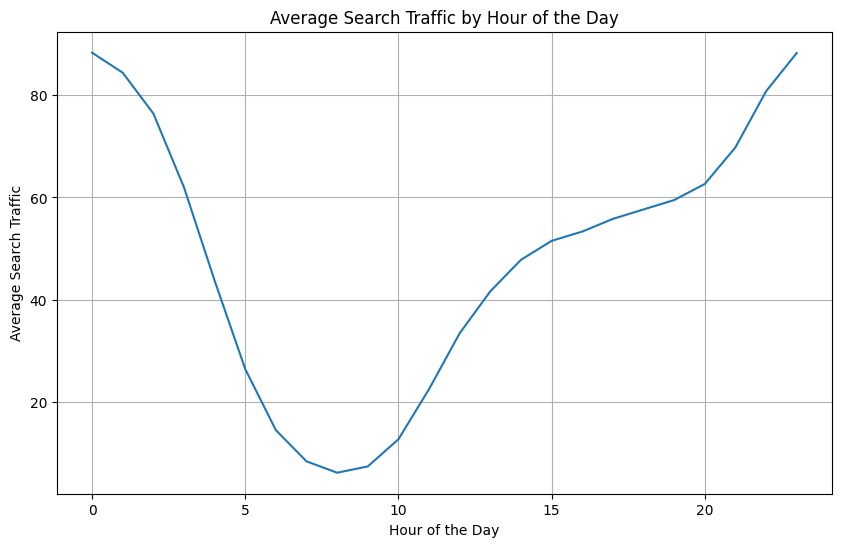

In [10]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.hour`
hourly_avg_traffic = df_mercado_trends.groupby(df_mercado_trends.index.hour)['Search Trends'].mean()
# Plot the average traffic by the hour of the day
plt.figure(figsize=(10, 6))
hourly_avg_traffic.plot()
plt.xlabel('Hour of the Day')
plt.ylabel('Average Search Traffic')
plt.title('Average Search Traffic by Hour of the Day')
plt.grid(True)
plt.show()

#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

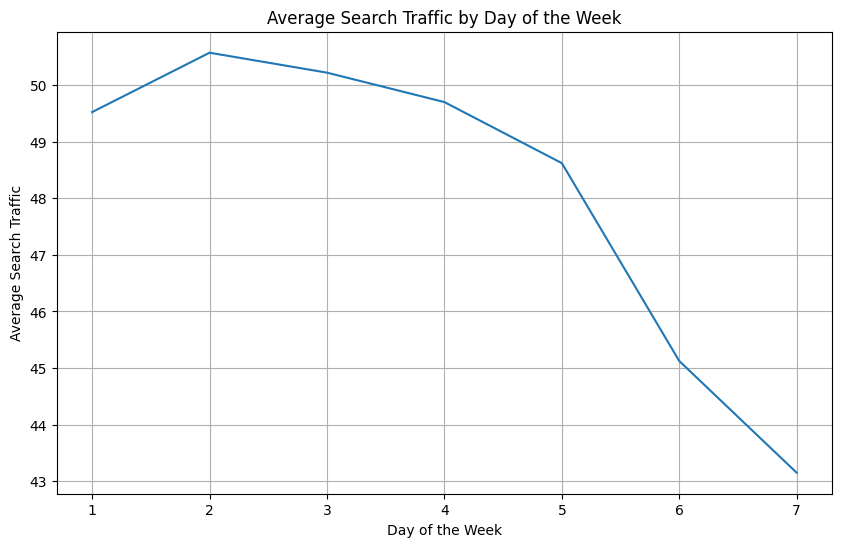

In [14]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.isocalendar().day`.
daily_avg_traffic = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().day)['Search Trends'].mean()
# Plot the average traffic by the day of the week
plt.figure(figsize=(10, 6))
daily_avg_traffic.plot()
plt.xlabel('Day of the Week')
plt.ylabel('Average Search Traffic')
plt.title('Average Search Traffic by Day of the Week')
plt.grid(True)
plt.show()

#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

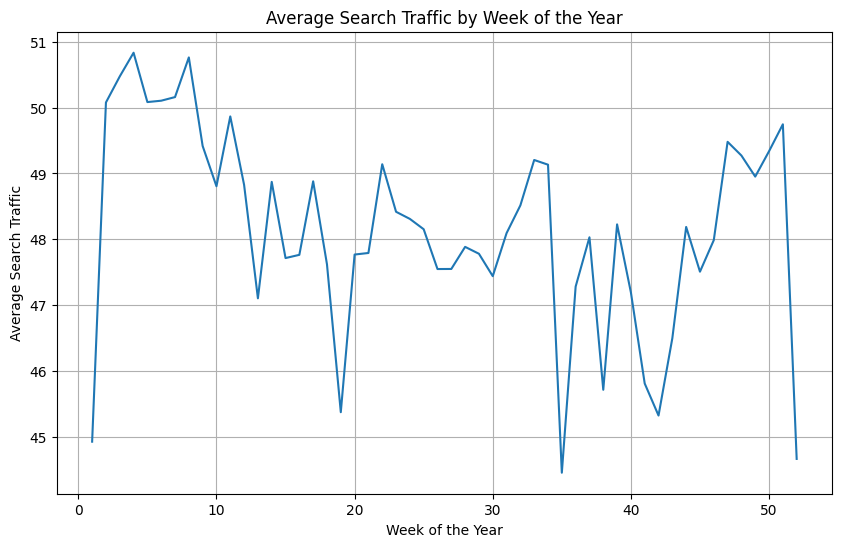

In [16]:
# Group the hourly search data to plot the average traffic by the week of the year using `df.index.isocalendar().week`.
weekly_avg_traffic = df_mercado_trends.groupby(df_mercado_trends.index.isocalendar().week)['Search Trends'].mean()
# Plot the average traffic by the week of the year
plt.figure(figsize=(10, 6))
weekly_avg_traffic.plot()
plt.xlabel('Week of the Year')
plt.ylabel('Average Search Traffic')
plt.title('Average Search Traffic by Week of the Year')
plt.grid(True)
plt.show()


##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:**
Yes, the data shows several time-based trends:

Weekly Fluctuations: The search traffic exhibits notable fluctuations across different weeks of the year.
Peaks and Troughs: There are distinct peaks in certain weeks, which could correspond to specific events or periods of increased interest, followed by troughs in other weeks.
Seasonal Patterns: The search traffic tends to increase during certain periods, potentially indicating seasonal trends or events that drive public interest.

## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [19]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# View the first and last five rows of the DataFrame
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


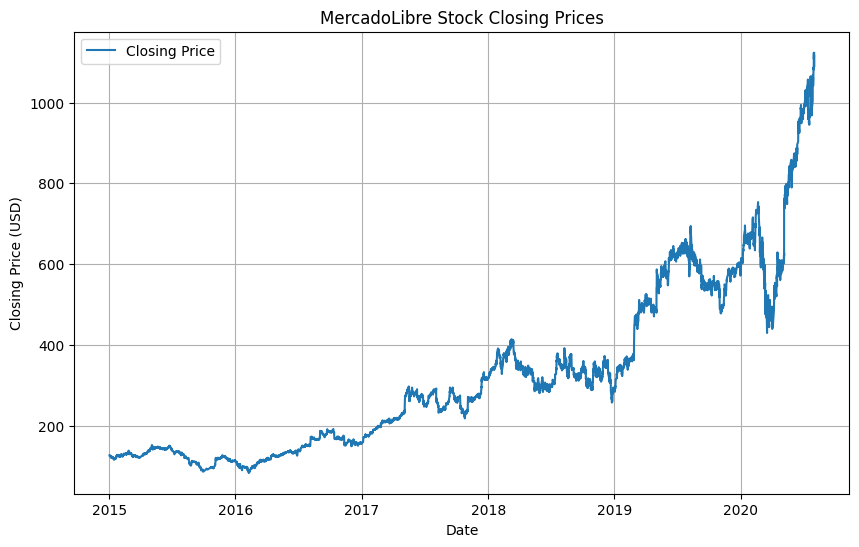

In [20]:
# Visualize the closing price of the df_mercado_stock DataFrame
# Plot the closing price of the df_mercado_stock DataFrame
import matplotlib.pyplot as plt # Import matplotlib for plotting
plt.figure(figsize=(10, 6))
plt.plot(df_mercado_stock.index, df_mercado_stock['close'], label='Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price (USD)')
plt.title('MercadoLibre Stock Closing Prices')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
df_combined = pd.concat([df_mercado_stock, df_mercado_trends], axis=1)
# Concatenate the DataFrame by columns (axis=1), and drop and rows with only one column of data
df_combined = df_combined.dropna(how='any')

# View the first and last five rows of the DataFrame
display(df_combined.head())
display(df_combined.tail())


,close,Search Trends
2016-06-01 09:00:00,135.16,6.0
2016-06-01 10:00:00,136.63,12.0
2016-06-01 11:00:00,136.56,22.0
2016-06-01 12:00:00,136.42,33.0
2016-06-01 13:00:00,136.10,40.0


,close,Search Trends
2020-07-31 11:00:00,1105.780,20.0
2020-07-31 12:00:00,1087.925,32.0
2020-07-31 13:00:00,1095.800,41.0
2020-07-31 14:00:00,1110.650,47.0
2020-07-31 15:00:00,1122.510,53.0


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [22]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
first_half_2020 = df_combined.loc['2020-01-01':'2020-06-30']

# View the first and last five rows of first_half_2020 DataFrame
display(first_half_2020.head())
display(first_half_2020.tail())

,close,Search Trends
2020-01-02 09:00:00,601.085,9.0
2020-01-02 10:00:00,601.290,14.0
2020-01-02 11:00:00,615.410,25.0
2020-01-02 12:00:00,611.400,37.0
2020-01-02 13:00:00,611.830,50.0


,close,Search Trends
2020-06-30 11:00:00,976.17,17.0
2020-06-30 12:00:00,977.50,27.0
2020-06-30 13:00:00,973.23,37.0
2020-06-30 14:00:00,976.50,45.0
2020-06-30 15:00:00,984.93,51.0


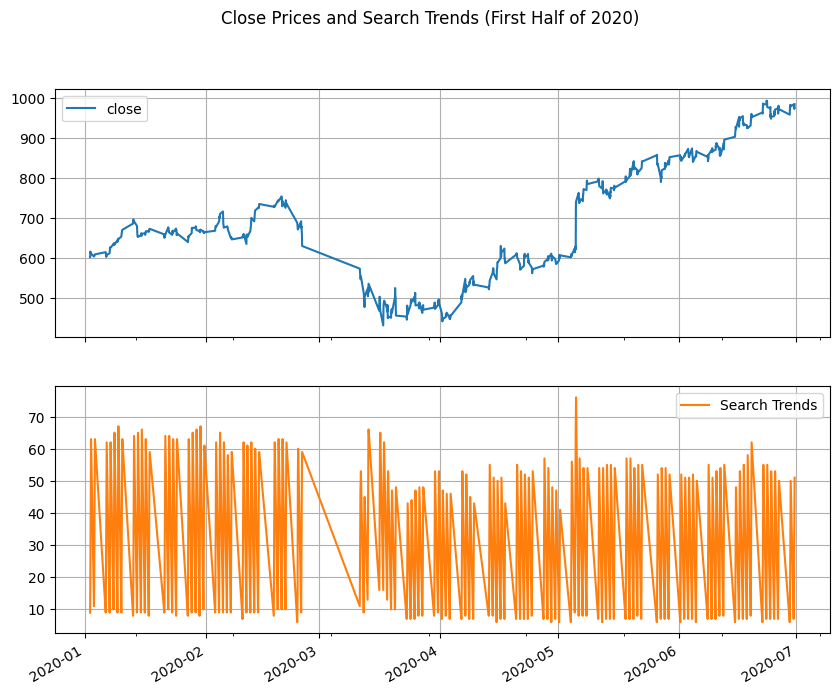

In [23]:
# Visualize the close and Search Trends data
# Plot each column on a separate axes using the following syntax
# `plot(subplots=True)`
first_half_2020[['close', 'Search Trends']].plot(subplots=True, figsize=(10, 8), grid=True, title='Close Prices and Search Trends (First Half of 2020)')
plt.show()


##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:**
Yes, both time series show a common trend consistent with the narrative:

Stock Prices: The stock prices initially dropped sharply, reflecting the global financial shock, but then recovered and increased steadily as the year progressed, indicating growing confidence and revenue in the e-commerce sector.
Search Trends: The search trends also show a pattern of initial fluctuations, followed by increased activity in May 2020, which aligns with the release of financial results and increased public interest.

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [25]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour
df_combined['Lagged Search Trends'] = df_combined['Search Trends'].shift(1)
# Calculate hourly returns first
df_combined['Hourly Stock Return'] = df_combined['close'].pct_change()

In [26]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window
df_combined['Stock Volatility'] = df_combined['Hourly Stock Return'].rolling(window=4).std().ewm(span=4).mean()


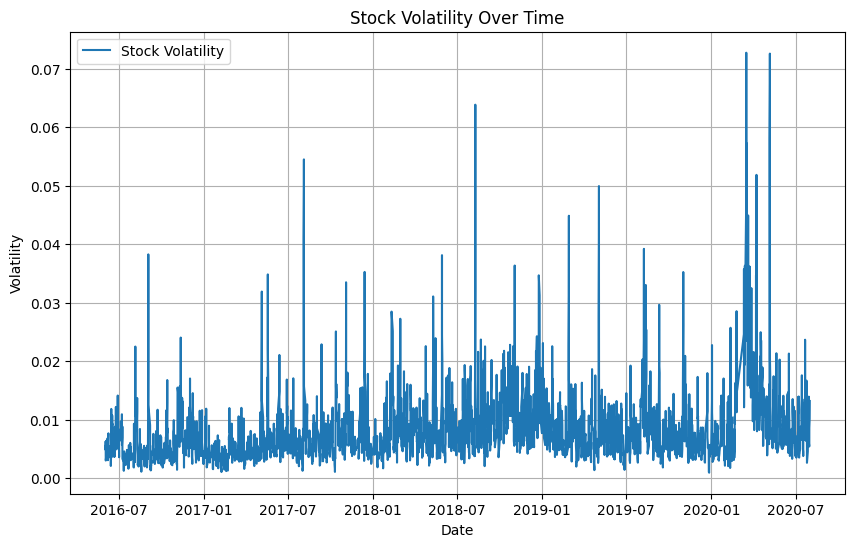

In [27]:
# Visualize the stock volatility
plt.figure(figsize=(10, 6))
plt.plot(df_combined.index, df_combined['Stock Volatility'], label='Stock Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Stock Volatility Over Time')
plt.legend()
plt.grid(True)
plt.show()


**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [30]:
# Create a sample DataFrame (replace with your actual data)
import pandas as pd
mercado_stock_trends_df = pd.DataFrame({'close': [100, 102, 105, 103, 107]})
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price
mercado_stock_trends_df['Hourly Stock Return'] = mercado_stock_trends_df['close'].pct_change()



In [31]:
# View the first and last five rows of the mercado_stock_trends_df DataFrame
display(mercado_stock_trends_df.head())

,close,Hourly Stock Return
0,100,NaN
1,102,0.020000
2,105,0.029412
3,103,-0.019048
4,107,0.038835


#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [ ]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
mercado_stock_trends_df[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()

,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.148938,0.061424
Lagged Search Trends,-0.148938,1.000000,0.017929
Hourly Stock Return,0.061424,0.017929,1.000000


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:**
Based on the correlation matrix:

Lagged Search Trends vs. Stock Volatility: There is a slightly negative correlation (-0.149838), suggesting that as lagged search trends increase, stock volatility tends to decrease, but the relationship is weak.
Lagged Search Trends vs. Hourly Stock Return: The correlation is close to zero (0.017929), indicating no significant relationship between lagged search trends and hourly stock returns.
There is no strong or predictable relationship between lagged search traffic and stock volatility or stock price returns based on the provided data.

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [32]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index
prophet_df = df_mercado_trends.reset_index()


# Label the columns ds and y so that the syntax is recognized by Prophet
prophet_df.columns = ['ds', 'y']

# Drop an NaN values from the prophet_df DataFrame
prophet_df = prophet_df.dropna()

# View the first and last five rows of the mercado_prophet_df DataFrame
display(prophet_df.head())
display(prophet_df.tail())

,ds,y
0,2016-06-01 00:00:00,97
1,2016-06-01 01:00:00,92
2,2016-06-01 02:00:00,76
3,2016-06-01 03:00:00,60
4,2016-06-01 04:00:00,38


,ds,y
37101,2020-09-07 20:00:00,71
37102,2020-09-07 21:00:00,83
37103,2020-09-07 22:00:00,96
37104,2020-09-07 23:00:00,97
37105,2020-09-08 00:00:00,96


In [33]:
# Call the Prophet function, store as an object
from prophet import Prophet
model = Prophet()

In [34]:
# Fit the time-series model.
model.fit(prophet_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp45wq9dtn/qpijrxyo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp45wq9dtn/n4t6d84a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24469', 'data', 'file=/tmp/tmp45wq9dtn/qpijrxyo.json', 'init=/tmp/tmp45wq9dtn/n4t6d84a.json', 'output', 'file=/tmp/tmp45wq9dtn/prophet_model_ml7wmqe/prophet_model-20240811220223.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:02:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:02:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [35]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
future_mercado_trends = model.make_future_dataframe(periods=2000, freq='H')

# View the last five rows of the future_mercado_trends DataFrame
display(future_mercado_trends.tail())

,ds
39101,2020-11-30 04:00:00
39102,2020-11-30 05:00:00
39103,2020-11-30 06:00:00
39104,2020-11-30 07:00:00
39105,2020-11-30 08:00:00


In [36]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
forecast_mercado_trends = model.predict(future_mercado_trends)

# Display the first five rows of the forecast_mercado_trends DataFrame
display(forecast_mercado_trends.head())

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-06-01 00:00:00,44.469500,80.500634,97.699009,44.469500,44.469500,45.159722,45.159722,45.159722,41.452703,...,1.860594,1.860594,1.860594,1.846426,1.846426,1.846426,0.0,0.0,0.0,89.629222
1,2016-06-01 01:00:00,44.470406,77.419166,95.058948,44.470406,44.470406,41.605529,41.605529,41.605529,37.943556,...,1.810498,1.810498,1.810498,1.851474,1.851474,1.851474,0.0,0.0,0.0,86.075935
2,2016-06-01 02:00:00,44.471312,67.078061,83.829664,44.471312,44.471312,31.282049,31.282049,31.282049,27.656646,...,1.768912,1.768912,1.768912,1.856491,1.856491,1.856491,0.0,0.0,0.0,75.753361
3,2016-06-01 03:00:00,44.472218,51.652415,68.522354,44.472218,44.472218,16.014826,16.014826,16.014826,12.417424,...,1.735926,1.735926,1.735926,1.861476,1.861476,1.861476,0.0,0.0,0.0,60.487045
4,2016-06-01 04:00:00,44.473124,35.052643,51.279888,44.473124,44.473124,-1.100073,-1.100073,-1.100073,-4.677999,...,1.711496,1.711496,1.711496,1.866430,1.866430,1.866430,0.0,0.0,0.0,43.373051


#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

/usr/local/lib/python3.10/dist-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


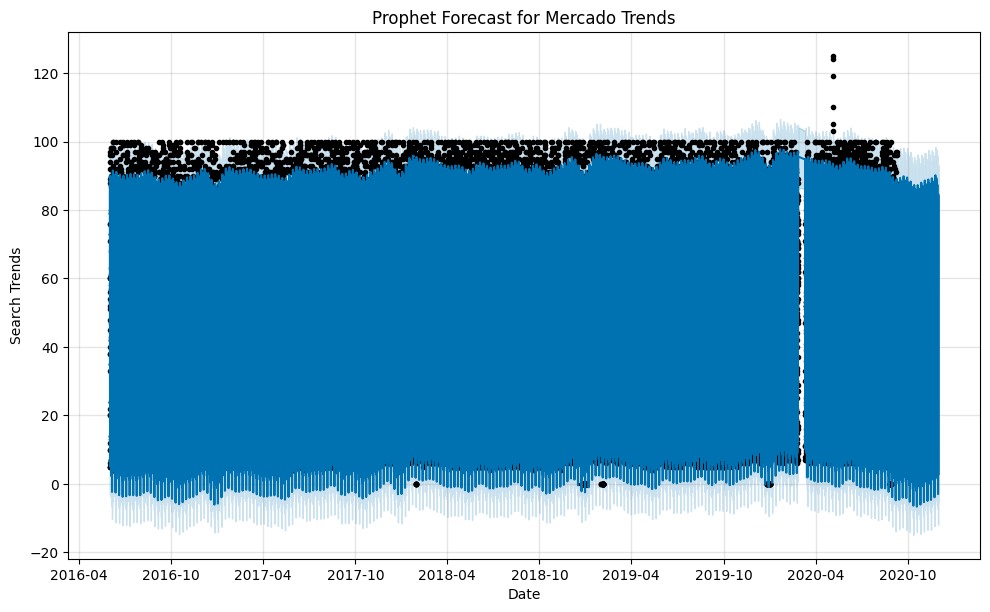

In [37]:
# Plot the Prophet predictions for the Mercado trends data
model.plot(forecast_mercado_trends)
plt.title('Prophet Forecast for Mercado Trends')
plt.xlabel('Date')
plt.ylabel('Search Trends')
plt.show()

##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:**
The near-term forecast for the popularity of MercadoLibre shows a positive trend. The predictions indicate that search trends are expected to remain stable or slightly increase in the upcoming days. This suggests sustained or growing interest in MercadoLibre, reflecting consistent user engagement and possibly correlating with continued business activity. The uncertainty intervals are relatively narrow, indicating a higher confidence in the forecasted values.


#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [55]:
# Check if 'ds' column exists
print(forecast_mercado_trends.columns)

# If 'ds' column exists, proceed with setting it as index
if 'ds' in forecast_mercado_trends.columns:
    # Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
    forecast_mercado_trends.set_index('ds', inplace=True)

    # View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame
    forecast_summary = forecast_mercado_trends[['yhat', 'yhat_lower', 'yhat_upper']]
    display(forecast_summary.head())
    display(forecast_summary.tail())
else:
    print("Error: 'ds' column not found in the DataFrame.")
    # *** Handle the missing 'ds' column here,
    #     e.g., by investigating how forecast_mercado_trends was created ***

Index(['trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')
Error: 'ds' column not found in the DataFrame.


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

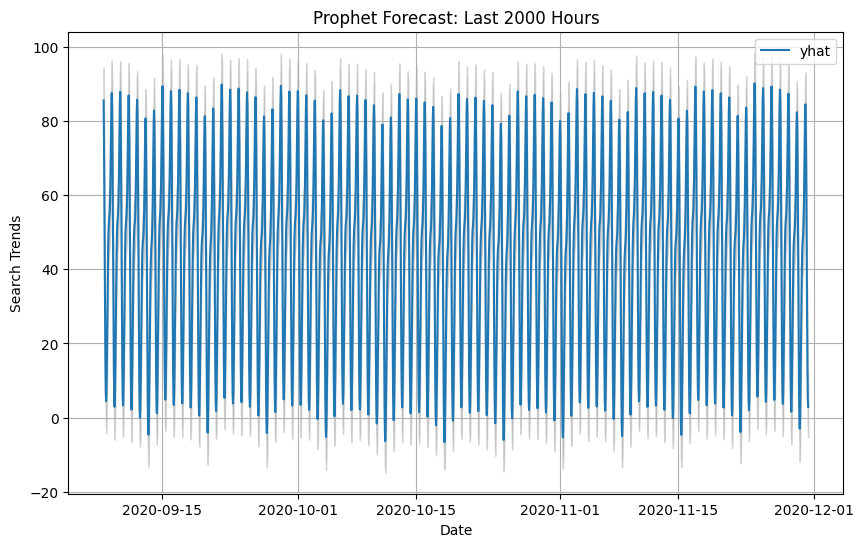

In [61]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours
plt.figure(figsize=(10, 6))
plt.plot(forecast_mercado_trends.index[-2000:], forecast_mercado_trends['yhat'][-2000:], label='yhat')
plt.fill_between(forecast_mercado_trends.index[-2000:], forecast_mercado_trends['yhat_lower'][-2000:], forecast_mercado_trends['yhat_upper'][-2000:], color='gray', alpha=0.3)

plt.title('Prophet Forecast: Last 2000 Hours')
plt.xlabel('Date')
plt.ylabel('Search Trends')
plt.legend()
plt.grid(True)
plt.show()

In [71]:
# Replace 'df' with the actual name of your DataFrame if it's different
print(df.columns)


Index(['ds', 'y'], dtype='object')


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
/usr/local/lib/python3.10/dist-packages/prophet/plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.ar

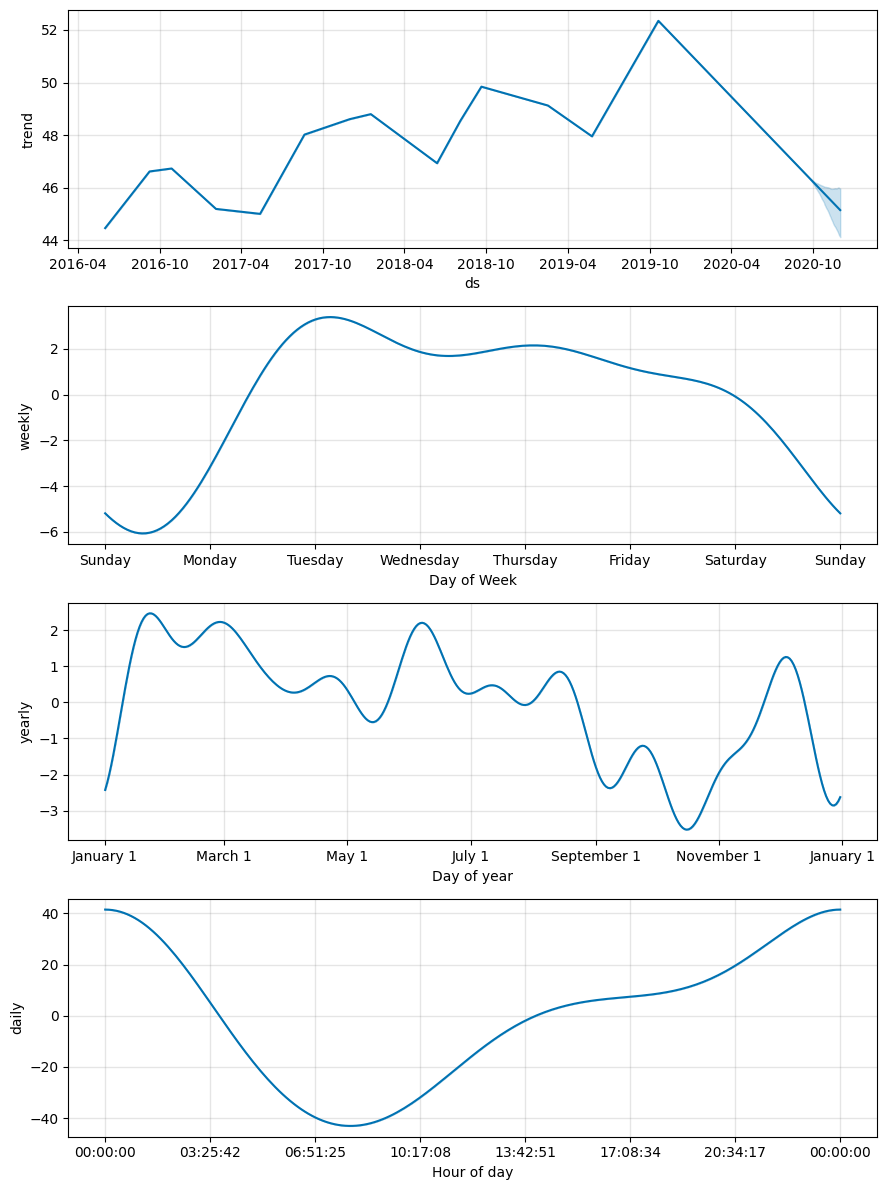

In [72]:
# Assuming your DataFrame is named 'df' and it has 'ds' and 'y' columns

# Reset the index in the forecast_mercado_trends DataFrame if necessary
if 'ds' not in forecast_mercado_trends.columns and 'ds' in forecast_mercado_trends.index.names:
    forecast_mercado_trends_reset = forecast_mercado_trends.reset_index()
else:
    forecast_mercado_trends_reset = forecast_mercado_trends

# Ensure the 'ds' column is present after resetting the index
if 'ds' not in forecast_mercado_trends_reset.columns:
    raise ValueError("The 'ds' column is still not found in the DataFrame after resetting the index.")

# Use the plot_components function to visualize the forecast results
model.plot_components(forecast_mercado_trends_reset)
plt.show()


##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:**
The greatest popularity occurs around midnight (00:00:00) and gradually increases again in the late evening (around 20:00 to midnight). The search traffic peaks during these times, indicating that users are most active during late evening hours and around midnight.

**Question:** Which day of week gets the most search traffic?
   
**Answer:**
As observed from the previous weekly seasonality plot, Monday has the highest search traffic, with activity gradually decreasing throughout the week.

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:**

The lowest points in search traffic occur in the mid-year (around July) and again in early September. There is also a significant drop in traffic towards the end of December. These dips could be due to holidays or periods of lower activity in the year.